In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn

In [2]:
# 3D Interactive Activations Visualization with Plotly

# Generate synthetic activations
torch.manual_seed(0)
x3 = torch.randn(200, 3) * 5 + 50  # deliberately large/shifted
ln3 = nn.LayerNorm(3)
x3_ln = ln3(x3).detach()

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "scene"}, {"type": "scene"}]],
    subplot_titles=("Before LayerNorm", "After LayerNorm")
)

# Before LN
fig.add_trace(
    go.Scatter3d(
        x=x3[:, 0].numpy(),
        y=x3[:, 1].numpy(),
        z=x3[:, 2].numpy(),
        mode='markers',
        marker=dict(size=4, opacity=0.7),
        name="Raw"
    ),
    row=1, col=1
)

# After LN
fig.add_trace(
    go.Scatter3d(
        x=x3_ln[:, 0].numpy(),
        y=x3_ln[:, 1].numpy(),
        z=x3_ln[:, 2].numpy(),
        mode='markers',
        marker=dict(size=4, opacity=0.7),
        name="LayerNorm"
    ),
    row=1, col=2
)

fig.update_layout(
    title="3D Activations: Before vs After LayerNorm",
    width=900,
    height=450
)

fig.show()


In [10]:
from matplotlib.animation import FuncAnimation

import torch.optim as optim
import matplotlib.pyplot as plt

# Generate synthetic training data
torch.manual_seed(42)
X_train = torch.randn(100, 10)
y_train = torch.randint(0, 2, (100,))

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, num_classes=2, ln=False):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.ln1 = nn.LayerNorm(hidden_dim) if ln else None
        self.ln2 = nn.LayerNorm(hidden_dim) if ln else None
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        if self.ln1:
            x = self.ln1(x)
        x = torch.relu(self.fc2(x))
        if self.ln2:
            x = self.ln2(x)
        return self.fc3(x)

def train_with_grad_flow(model, lr=1e-3, epochs=40):
    opt = optim.Adam(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    
    loss_history = []
    grad_norm_history = []
    
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()

        logits = model(X_train)
        loss = ce(logits, y_train)
        loss.backward()

        layer_grads = {}
        # Fix: safely capture gradient norms
        for name, p in model.named_parameters():
            if p.grad is not None:
                layer_grads[name] = p.grad.norm().item()
            else:
                layer_grads[name] = 0.0
        
        grad_norm_history.append(layer_grads)
        opt.step()
        loss_history.append(loss.item())
    
    return loss_history, grad_norm_history
    
model_base_gf = SimpleMLP(ln=False)
model_ln_gf   = SimpleMLP(ln=True)

loss_base_gf, grads_base = train_with_grad_flow(model_base_gf)
loss_ln_gf,   grads_ln   = train_with_grad_flow(model_ln_gf)

print("Done. Final losses -> base:", loss_base_gf[-1], "  ln:", loss_ln_gf[-1])

Done. Final losses -> base: 0.5207898020744324   ln: 0.19125929474830627


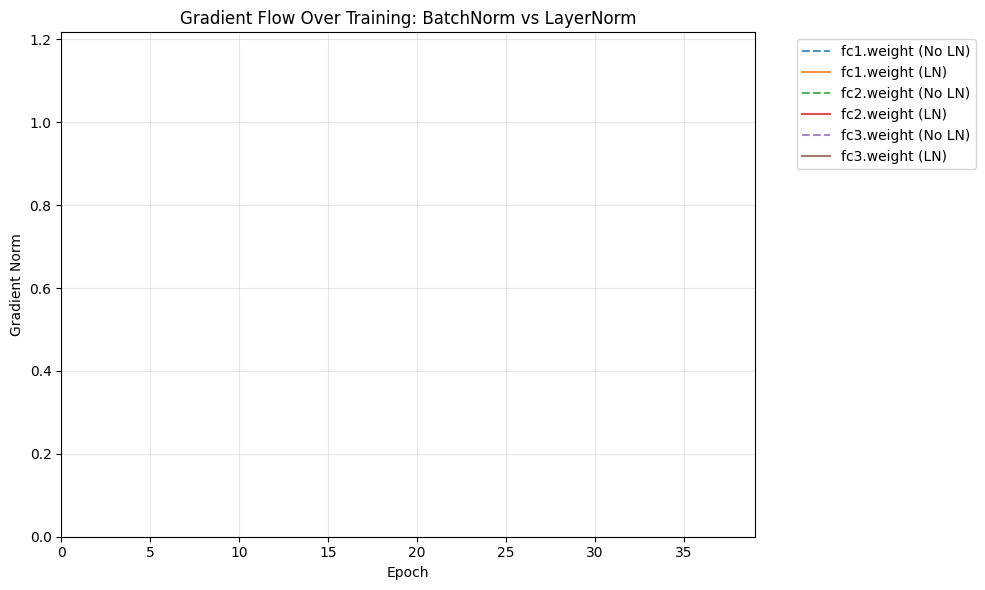

In [12]:
# Pick a few parameter names to visualize
# (filter to avoid clutter, e.g. only weights, not biases)
def filter_param_names(grad_hist, max_params=4):
    all_names = list(grad_hist[0].keys())
    names = [n for n in all_names if "weight" in n][:max_params]
    return names

# Filter to only include parameters that exist in both models
param_names = filter_param_names(grads_base, max_params=3)  # Exclude ln1.weight since it doesn't exist in base model

# Precompute per-param sequences
def extract_grad_series(grad_hist, names):
    series = {name: [] for name in names}
    for gdict in grad_hist:
        for name in names:
            series[name].append(gdict.get(name, 0.0))
    return series

series_base = extract_grad_series(grads_base, param_names)
series_ln   = extract_grad_series(grads_ln, param_names)

epochs = len(loss_ln_gf)

fig, ax = plt.subplots(figsize=(10,6))
lines_base = {}
lines_ln = {}

# Create line objects for each parameter
for name in param_names:
    line_b, = ax.plot([], [], label=f"{name} (No LN)", linestyle='--', alpha=0.8)
    line_l, = ax.plot([], [], label=f"{name} (LN)", alpha=0.8)
    lines_base[name] = line_b
    lines_ln[name] = line_l

ax.set_xlim(0, epochs-1)
ax.set_ylim(
    0,
    max(max(max(v) for v in series_base.values()),
        max(max(v) for v in series_ln.values())) * 1.1
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Gradient Norm")
ax.set_title("Gradient Flow Over Training: BatchNorm vs LayerNorm")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

def update(frame):
    x = list(range(frame+1))
    for name in param_names:
        yb = series_base[name][:frame+1]
        yl = series_ln[name][:frame+1]
        lines_base[name].set_data(x, yb)
        lines_ln[name].set_data(x, yl)
    return list(lines_base.values()) + list(lines_ln.values())

ani_grad = FuncAnimation(fig, update, frames=epochs, interval=150, blit=True, repeat=True)
plt.tight_layout()
plt.show()


In [13]:
class LSTM_BN(nn.Module):
    """
    LSTM + BatchNorm on hidden states (time-flattened).
    """
    def __init__(self, input_dim=10, hidden_dim=32, num_layers=1, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # x: (B, T, D)
        out, _ = self.lstm(x)  # (B, T, H)
        B, T, H = out.shape
        out_reshaped = out.contiguous().view(-1, H)
        out_bn = self.bn(out_reshaped).view(B, T, H)
        last = out_bn[:, -1, :]  # last time-step
        return self.fc(last)


class LSTM_LN(nn.Module):
    """
    LSTM + LayerNorm on hidden states per time-step.
    """
    def __init__(self, input_dim=10, hidden_dim=32, num_layers=1, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.ln = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # (B, T, H)
        out_ln = self.ln(out)  # LN over feature dim
        last = out_ln[:, -1, :]
        return self.fc(last)


In [14]:
# Dummy sequence classification data
B, T, D = 64, 20, 10
X_seq = torch.randn(B, T, D)
y_seq = torch.randint(0, 2, (B,))

def train_one_step(model, X, y):
    opt = optim.Adam(model.parameters(), lr=1e-3)
    ce = nn.CrossEntropyLoss()
    model.train()
    opt.zero_grad()
    logits = model(X)
    loss = ce(logits, y)
    loss.backward()
    opt.step()
    return loss.item()

rnn_bn = LSTM_BN()
rnn_ln = LSTM_LN()

print("One step RNN BN loss:", train_one_step(rnn_bn, X_seq, y_seq))
print("One step RNN LN loss:", train_one_step(rnn_ln, X_seq, y_seq))


One step RNN BN loss: 0.7365180253982544
One step RNN LN loss: 0.6820970773696899


In [15]:
class CNN_BN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2)
        self.fc    = nn.Linear(64 * 7 * 7, num_classes)  # assuming 28x28 input
    
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)


class CNN_LN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.ln1   = nn.LayerNorm([32, 28, 28])  # normalize over C,H,W
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.ln2   = nn.LayerNorm([64, 14, 14])  # after first pool
        self.pool  = nn.MaxPool2d(2)
        self.fc    = nn.Linear(64 * 7 * 7, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x)
        x = torch.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.ln2(x)
        x = torch.relu(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [16]:
x_img = torch.randn(16, 1, 28, 28)
cnn_bn = CNN_BN()
cnn_ln = CNN_LN()

print("CNN BN output shape:", cnn_bn(x_img).shape)
print("CNN LN output shape:", cnn_ln(x_img).shape)


CNN BN output shape: torch.Size([16, 10])
CNN LN output shape: torch.Size([16, 10])


In [17]:
class TransformerBlock_LN(nn.Module):
    def __init__(self, d_model=64, nhead=4, dim_ff=128):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.ln1  = nn.LayerNorm(d_model)
        self.ff   = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, d_model)
        )
        self.ln2  = nn.LayerNorm(d_model)
    
    def forward(self, x):
        # x: (B, T, d_model)
        attn_out, _ = self.attn(x, x, x)
        x = self.ln1(x + attn_out)
        ff_out = self.ff(x)
        x = self.ln2(x + ff_out)
        return x


class TransformerBlock_BN(nn.Module):
    """
    Not standard, but demonstrates BN vs LN.
    BN is applied across batch*time, per feature.
    """
    def __init__(self, d_model=64, nhead=4, dim_ff=128):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.bn1  = nn.BatchNorm1d(d_model)
        self.ff   = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, d_model)
        )
        self.bn2  = nn.BatchNorm1d(d_model)
    
    def forward(self, x):
        # x: (B, T, d_model)
        B, T, D = x.shape
        
        attn_out, _ = self.attn(x, x, x)
        z1 = x + attn_out  # (B, T, D)
        z1_flat = z1.view(-1, D)
        z1_bn = self.bn1(z1_flat).view(B, T, D)
        
        ff_out = self.ff(z1_bn)
        z2 = z1_bn + ff_out
        z2_flat = z2.view(-1, D)
        z2_bn = self.bn2(z2_flat).view(B, T, D)
        return z2_bn


In [18]:
x_seq = torch.randn(8, 10, 64)  # (batch, seq_len, d_model)
tb_ln = TransformerBlock_LN()
tb_bn = TransformerBlock_BN()

out_ln = tb_ln(x_seq)
out_bn = tb_bn(x_seq)

print("Transformer LN out:", out_ln.shape)
print("Transformer BN out:", out_bn.shape)


Transformer LN out: torch.Size([8, 10, 64])
Transformer BN out: torch.Size([8, 10, 64])
